In [72]:
# compare the data/mc for cluster shape/position, variables used for BDT training

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [73]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
ver = 'V1p17'
sig_ver = 'v160'
year='2017'
singleMuon = True
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver+'/normalized/'
bkg_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'


lumi = 41.53*1000


fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'
# fpath_bkg['dy_50_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_50_800_1pb_weighted.root'

fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
# sig_ver = 'v152'
# data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver+'/normalized/'
# fpath_bkg['data_152'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"


In [74]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

dy_120_800 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v160/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
[-8.627941  -1.2055961 -0.1042499  0.1042499  1.2055961  8.627941 ]
(140315,)
data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v160/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
[41530.]
(344706,)


# DY MC mass comparision (no cluster requirement)

In [ ]:
%%time

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
mc_corr_weight = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
sel_tp = {}
lepSF = {}
muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
for (m1,m2) in masses:
    keys = ['data', 'dy_'+m1+'_'+m2]
    for k in ['data', 'dy_'+m1+'_'+m2]:
        T = tree_bkg[k]
#         if k == 'data':continue
    # ########### BRANCHES ############
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1

        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        print(k,np.count_nonzero(sel_ev[k]))
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        print(k,np.count_nonzero(sel_ev[k]))


        if m1 == '50':
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(60))
        else:
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
        probe_index[k] = []
        sel_tp[k] = []
        index = 0
        for i, ev in enumerate(sel_ev[k]):
            if ev:
                if sel_lep[k][i][0]:
                    probe_index[k].append([False,True])
                    sel_tp[k].append(index)
                if sel_lep[k][i][1]:
                    probe_index[k].append([True, False])
                    sel_tp[k].append(index)
                index+=1
        sel_tp[k] = np.array(sel_tp[k])
        probe_index[k] = np.array(probe_index[k])
        weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
        if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]]
        ZMass[k]= T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]][sel_tp[k]]
        rho[k]= T.array('rho')[sel_ev[k]][sel_tp[k]]
        npv[k]= T.array('npv')[sel_ev[k]][sel_tp[k]]
        npu[k]= T.array('npu')[sel_ev[k]][sel_tp[k]]

        print("here")
        mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        # with pT > 50
        if norm == 50:
            #V14 after fixing tag and probe counting issue
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
        elif norm == 25:#need to rerun
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 0.91870093
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1795386
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.5143042
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4587245
        elif norm == 30:

            #v14 with lepton sf applied
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 0.94598883
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1833522
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.5155867
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4747782        
        lepE[k] = np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepEta[k] = np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepPt[k] = np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        if k[:2] == 'dy': lepSF[k] = np.array(T.array('lepSF')[sel_ev[k]][sel_tp[k]])[probe_index[k]]


        lepE[k] = np.array(lepE[k])
        lepEta[k] = np.array(lepEta[k])
        lepPt[k] = np.array(lepPt[k])
        if k[:2] == 'dy':lepSF[k] = np.array(lepSF[k])

        if k[:4] == 'data':
            pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
            weight[k] = weight[k] * 0.0 + 1.0
            mc_corr_weight[k] = weight[k] * 0.0 + 1.0
#     print(m1,m2, len(weight['data']), len(lepE[k]), np.sum(weight['data']*pileupWeight['data'])/np.sum(lepOverallSF['dy_'+m1+'_'+m2]* weight['dy_'+m1+'_'+m2]*pileupWeight['dy_'+m1+'_'+m2]))



/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148
672506 672506
data 672506.0 672506.0
274165 274165
dy_120_800 674791.8206850078 674791.9
ZMass 0.9966125542501576


Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/2017_norm50_V1p17v148_tag_probe/ZMass_Zmass120_800_muon50_norm50_log.png has been created
Info in <

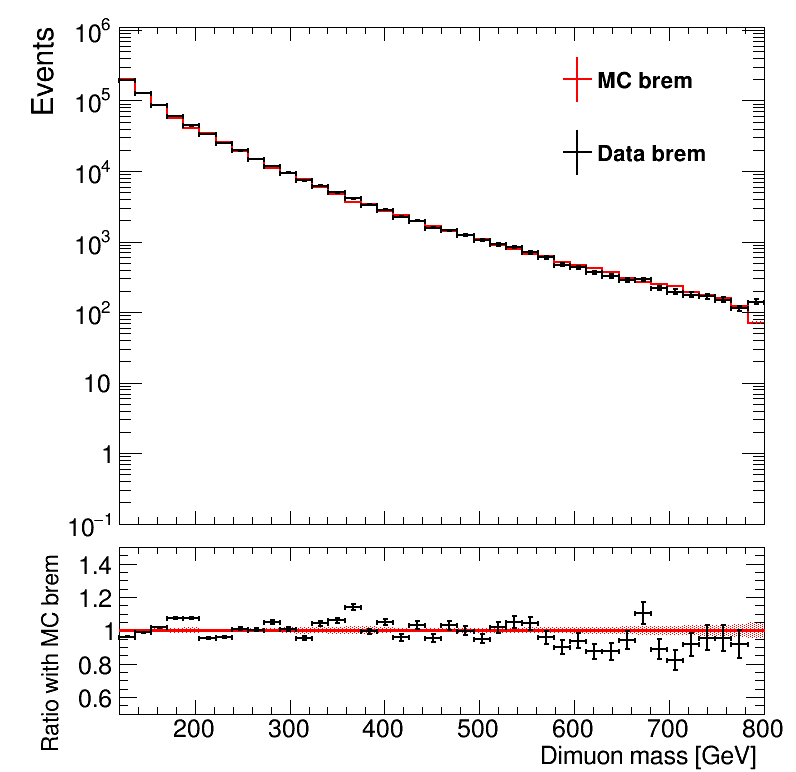

In [67]:
############ PLOTTING #########
import os
h = {}

var = [ZMass, ZMass, ZPt, lepPt, lepE, lepEta]
title = ['Dimuon mass [GeV]','Dimuon mass [GeV]', 'Z p_{T} [GeV]', 'muon pT [GeV]', 'muon E [GeV]', 'muon #eta']

bins = [ [40,int(m1),int(m2)],[25,50,120],  list(np.arange(0,300,25))+[300, 350, 400,500,800], list(np.arange(0,300,25))+[300, 350, 400,500,800], list(np.arange(0,500,50))+[500,575, 650, 725,800,900,1000]+[1200, 1600, 2000], [20,0.0,2.5],]
# bins = [ [40,int(m1),int(m2)],[25,50,120], list(np.arange(0,300,25))+[300, 350, 400,500,800], [50,0,2000], [20,0.0,2.5],]


reweight = False

names = ['ZMass', 'ZMass50_120','ZPt', 'cscRechitCluster2IsoMuonVetoPt', 'cscRechitCluster2IsoMuonVetoE', 'cscRechitCluster2IsoMuonVetoEta']
assert(len(var) == len(title) == len(names) == len(bins) )
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/simulation_modelling/'+year+\
'_norm'+str(norm)+'_'+ver+sig_ver
print(dir_name)
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)
keys = ['data', 'dy_'+m1+'_'+m2]
for j, v in enumerate(var):
    if int(m1) >= 120 and j == 1:continue
    if not j == 0:continue
    for i,k in enumerate(keys):
        if k[:2] == 'dy': total_weight = weight[k]*lepOverallSF[k]*pileupWeight[k]*mc_corr_weight[k]
        else: total_weight = weight[k]
        print(len(total_weight), len(var[j][k]))
        if reweight:
            h_reweight = {}
            h_reweight['mc_reweight'] = create_TH1D( np.abs(ZPt[k]), axis_title=['ZPt', 'Events'], name=k, binning=bins[2], weights = total_weight)
            h_reweight['data_reweight'] = create_TH1D( np.abs(ZPt['data']), axis_title=['ZPt', 'Events'], name='data', binning=bins[2], weights = weight['data']*pileupWeight['data']*mc_corr_weight['data'])
            h_reweight['data_reweight'].Divide(h_reweight['mc_reweight'])
            reweight = []
            for m in range(len(ZPt[k])):
                reweight.append(h_reweight['data_reweight'].GetBinContent(h_reweight['data_reweight'].GetXaxis().FindFixBin(np.abs(ZPt[k])[m])))
            total_weight *= reweight
        cond = ZMass[k]>=0
        h[k] = create_TH1D( np.abs(var[j][k][cond].flatten()), axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[cond])

        print(k, h[k].Integral(), np.sum(total_weight))

        h[k].SetLineColor(std_color_list[i])
    print(names[j], h[keys[0]].Integral()*1.0/h[keys[1]].Integral())


    c = make_ratio_plot([h[keys[1]],h[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.5,1.5], draw_opt = ['E2','E1']) 
    c.Draw()
    if reweight:
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight.C')
    else:
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
    c_log = make_ratio_plot([h[keys[1]],h[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.5,1.5], draw_opt = ['E2','E1']) 
    c_log.Draw()
    if reweight:
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight_log.png')
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_ZptReweight_log.C')
    else:
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
        c_log.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
# for i in range(74):
#     print(i+1, h[keys[0]].GetBinCenter(i+1), h[keys[0]].GetBinContent(i+1)/h[keys[1]].GetBinContent(i+1))


In [4]:
h_eta_edges = np.array(list(np.arange(0.8,2.1,0.1)))
h_eta_values = np.array([0.9833463,1.010997,0.9999217,0.9912782,0.9924796,0.9609472,0.9614409,0.9760263,0.9432919,0.9553725,0.9648235,0.9253925])


# cluster level variables (matched to probe muon, all mass bins)

In [75]:
%%time

sel_tp = {}
pileupWeight = {}
weight = {}
clusterSize = {}
clusterEta = {}
clusterTimeSpread = {}
clusterTimeSpreadWeighted = {}
clusterTimeSpreadWeightedAll = {}
clusterTimeTotal = {}
clusterTimeWeighted = {}
clusterMe11Ratio = {}
clusterMB1Ratio = {}
clusterMatchMB1 = {}
clusterMatchRPC = {}
clusterMaxStation = {}
sel_lep = {}
sel_ev = {}
cut_based = {}
probe_index = {}
sel_tp = {}
cond = {}
mc_corr_weight = {}
clusterNSegmentStation1 = {}
clusterNSegmentStation2 = {}
clusterNSegmentStation3 = {}
clusterNSegmentStation4 = {}
nNoiseHitsStation1 = {}
nNoiseHitsStation2 = {}
nNoiseHitsStation3 = {}
nNoiseHitsStation4 = {}
clusterNStation = {}
clusterStationRatio = {}
clusterNStationNoise = {}
clusterStationRatioNoise = {}
clusterSizeNoise = {}
ZMass = {}
lepEta = {}
muonEta_weight = {}
muonPt = 50
tag_probe = True
norm = False
text = False
scaling = 'norm'
m1, m2 = '120', '800' 
# m1, m2 = '60', '120' 
# m1, m2 = '60', '120' 
region = 'dt'
# for k in ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]:
for k, T in tree_bkg.items():
#     if not '152' in k:continue
#     if k[:4] == 'data': T = tree_bkg['data']
#     else: T = tree_bkg['dy_120_800']
    sel_cluster = np.abs(T.array(region+ 'RechitClusterSize'))>=0
    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array(region+ 'RechitClusterZLep1') == 1, T.array(region+ 'RechitClusterZLep2') == 1))
    if k[:2] == 'dy':sel_cluster = np.logical_and(sel_cluster, T.array(region+ 'RechitClusterGenMuonVetoPt') > muonPt)
    if tag_probe: 
        sel_cluster1 =np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep1') == 1)   #loose lepton
        sel_cluster2 = np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep2') == 1)  

# ########### BRANCHES ############
    sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
    sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
    sel_ev[k] = sel_lep[k].sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
    print(k, np.count_nonzero(sel_ev[k]))


    if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
    if m1 == '50':
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=60)
    else:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))

    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
    print(k, np.count_nonzero(sel_ev[k]))
    probe_index[k] = []
    sel_tp[k] = []
    cond[k] = []
    sel_probecluster = []
    pdgid = T.array("lepPdgId")


    index = 0
    for i, ev in enumerate(sel_ev[k]):
        if ev:
            if sel_lep[k][i][0]:#first lepton is tight
                probe_index[k].append([False,True])
                sel_tp[k].append(index)
                if pdgid[i][0] == 13:
#                     cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    cond[k].append(sel_cluster2[i].sum()==1)
                    if cond[k][-1]: sel_probecluster.append(sel_cluster2[i])
                else:
                    cond[k].append(sel_cluster1[i].sum()==1)
                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            if sel_lep[k][i][1]:#second lepton is tight
                probe_index[k].append([True, False])
                sel_tp[k].append(index)
                if pdgid[i][0] == -13:
#                     cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    cond[k].append(sel_cluster2[i].sum()==1)
                    if cond[k][-1]:sel_probecluster.append(sel_cluster2[i])
                else:
#                     cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    cond[k].append(sel_cluster1[i].sum()==1)

                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            index+=1
    sel_tp[k] = np.array(sel_tp[k])
    probe_index[k] = np.array(probe_index[k])

    cond[k] = np.array(cond[k])
    sel_probecluster = awkward.fromiter(sel_probecluster)
    clusterEta[k] = awkward.fromiter(T.array(region+ 'RechitClusterEta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    clusterSize[k] = awkward.fromiter(T.array(region+ 'RechitClusterSize')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    print(k, len(clusterSize[k]))
    if region == 'csc':
        clusterTimeSpread[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpread')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeSpreadWeighted[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpreadWeighted')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeSpreadWeightedAll[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpreadWeightedAll')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeTotal[k] = awkward.fromiter(T.array('cscRechitClusterTimeTotal')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeWeighted[k] = awkward.fromiter(T.array('cscRechitClusterTimeWeighted')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMe11Ratio[k] = awkward.fromiter(T.array('cscRechitClusterMe11Ratio')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    else:
        clusterMB1Ratio[k] = awkward.fromiter((T.array('dtRechitClusterNSegmentStation1')/T.array('dtRechitClusterSize'))[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchRPC[k] = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchMB1[k] = awkward.fromiter(T.array('dtRechitCluster_match_MB1hits_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMaxStation[k] = awkward.fromiter(T.array('dtRechitClusterMaxStation')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        
        clusterNSegmentStation1[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation1')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation2[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation2')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation3[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation3')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterNSegmentStation4[k] = awkward.fromiter(T.array('dtRechitClusterNSegmentStation4')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

        if 'data' in k:
            nNoiseHitsStation1[k] = np.zeros(clusterNSegmentStation1[k].shape)
            nNoiseHitsStation2[k] = np.zeros(clusterNSegmentStation1[k].shape)
            nNoiseHitsStation3[k] = np.zeros(clusterNSegmentStation1[k].shape)
            nNoiseHitsStation4[k] = np.zeros(clusterNSegmentStation1[k].shape)

        else:
            prob = 0.03
            nNoiseHitsStation1[k] =  np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(clusterNSegmentStation2[k]),12))<prob,axis=1)
            nNoiseHitsStation2[k] =  np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(clusterNSegmentStation2[k]),12))<prob,axis=1)
            nNoiseHitsStation3[k] =  np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(clusterNSegmentStation2[k]),12))<prob,axis=1)
            nNoiseHitsStation4[k] =  np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(clusterNSegmentStation2[k]),8))<prob,axis=1)

#             nNoiseHitsStation1[k] = np.zeros(clusterNSegmentStation1[k].shape)
#             nNoiseHitsStation2[k] = np.zeros(clusterNSegmentStation1[k].shape)
#             nNoiseHitsStation3[k] = np.zeros(clusterNSegmentStation1[k].shape)
#             nNoiseHitsStation4[k] = np.zeros(clusterNSegmentStation1[k].shape)
        cut = 5
        clusterNStation[k] = ((T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int))[sel_ev[k]][sel_tp[k]][cond[k]][sel_probecluster][:,0]

        max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        clusterStationRatio[k] = (min_station/max_station)[sel_ev[k]][sel_tp[k]][cond[k]][sel_probecluster][:,0]


        
        clusterNStationNoise[k] = ((nNoiseHitsStation1[k]+clusterNSegmentStation1[k]>cut).astype(int)+(nNoiseHitsStation2[k]+clusterNSegmentStation2[k]>cut).astype(int)\
    +(nNoiseHitsStation3[k]+clusterNSegmentStation3[k]>cut).astype(int)+(nNoiseHitsStation4[k]+clusterNSegmentStation4[k]>cut).astype(int))
        max_station = np.maximum(np.maximum(np.maximum(nNoiseHitsStation1[k]+clusterNSegmentStation1[k], nNoiseHitsStation2[k]+clusterNSegmentStation2[k]), \
                                            nNoiseHitsStation3[k]+clusterNSegmentStation3[k]), nNoiseHitsStation4[k]+clusterNSegmentStation4[k])
        min_station = np.minimum(np.minimum(np.minimum(nNoiseHitsStation1[k]+clusterNSegmentStation1[k], nNoiseHitsStation2[k]+clusterNSegmentStation2[k]), \
                                            nNoiseHitsStation3[k]+clusterNSegmentStation3[k]), nNoiseHitsStation4[k]+clusterNSegmentStation4[k])        
        clusterStationRatioNoise[k] = min_station/max_station

        clusterSizeNoise[k] = clusterSize[k] + nNoiseHitsStation1[k] + nNoiseHitsStation2[k] + nNoiseHitsStation3[k] + nNoiseHitsStation4[k]

    ##### weight variables ####
#     weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]][cond[k]]*lumi
#     if k[:2] == 'dy': weight[k] *= T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]][cond[k]]
#     pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]][cond[k]]
#     ZMass[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]][cond[k]]
#     mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]][cond[k]]
#     lepEta[k] = np.stack(np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]]))[cond[k]][probe_index[k][cond[k]]]
#     muonEta_weight[k] = h_eta_values[np.argmax(h_eta_edges>lepEta[k][:,None],axis=1)-1]
#     if k[:2] == 'dy':
#         mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
#         mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
#         mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
#         mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
#     if k[:4] == 'data':
#         pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
#         weight[k] = weight[k] * 0.0 + 1.0
#         mc_corr_weight[k] = weight[k] * 0.0 + 1.0
#         muonEta_weight[k] = muonEta_weight[k]*0.0 + 1.0

    #### weight variables before cluster requirement ####
    weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
    if k[:2] == 'dy': weight[k] *= T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]]
    pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
    ZMass[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
    mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
    if k[:2] == 'dy':
        mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
        mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
        mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
        mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
    if k[:4] == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
        mc_corr_weight[k] = weight[k] * 0.0 + 1.0
    lepEta[k] = np.stack(np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]]))[probe_index[k]]



dy_120_800 140180
dy_120_800 138739
dy_120_800 93075
data 343998
data 342046
data 53321
CPU times: user 1min 32s, sys: 1.08 s, total: 1min 33s
Wall time: 1min 34s


In [58]:
region

'csc'

# CSC cluster 

/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year2017_muonShower_norm_V1p17v160_tag_probe/
4 4 4 4
data clusterTimeWeighted efficiency 0.9891276210199327 0.0011787830695011436 0.0013123511199882865
<nullptr TFitResult>
dy_120_800 clusterTimeWeighted efficiency 0.9897252710287631 0.0032520249274644586 0.0032520249274644586
<nullptr TFitResult>
 FCN=141.228 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=2.16994e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.21507e+03   3.29670e+01   1.48279e-01   3.17495e-06
   2  Mean        -7.88398e-03   1.57298e-02   9.12797e-05  -4.10420e-02
   3  Sigma        1.36334e+00   1.28885e-02   1.30268e-05  -3.70338e-02
 FCN=48.2251 FROM MIGRAD    STATUS=CONVERGED

Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year2017_mu

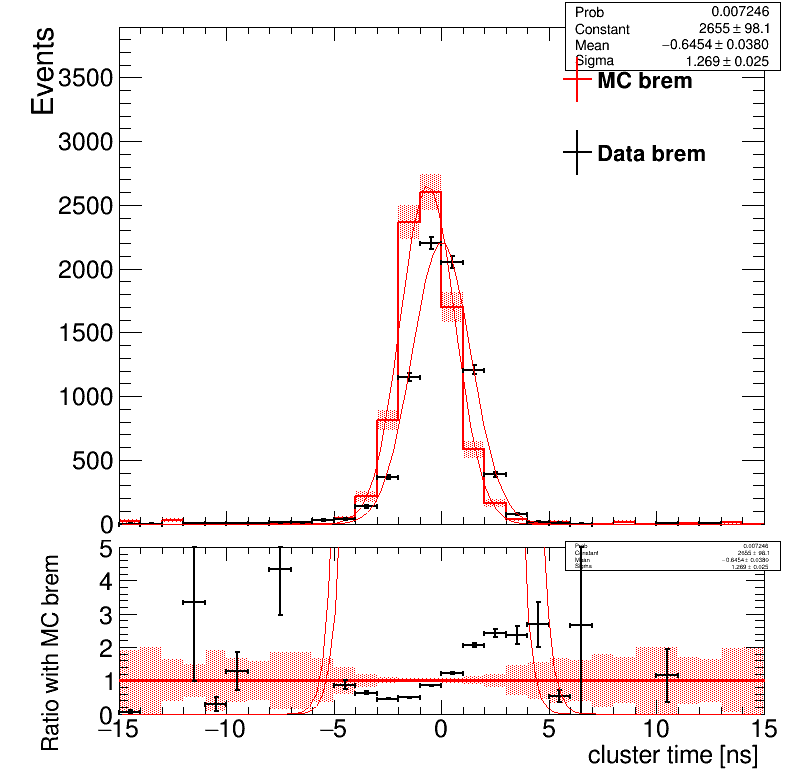

In [62]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff

rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year'+year+\
'_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)

if not region =='csc':assert(False)
Nrechits_cut = 100
# var = [clusterSize, clusterTimeTotal, clusterTimeSpread,clusterMe11Ratio, clusterTimeWeighted, clusterTimeSpreadWeighted, clusterTimeSpreadWeightedAll]
# names = ['clusterSize', 'clusterTimeTotal', 'clusterTimeSpread','clusterMe11Ratio', 'clusterTimeWeighted', 'clusterTimeSpreadWeighted', 'clusterTimeSpreadWeightedAll']
# title = ['N_{rechits}',  'cluster time [ns]','cluster strip time spread [ns]', 'ME11 ratio',  'cluster time [ns]','cluster strip time spread [ns]','cluster strip time spread [ns]']
         
var = [clusterSize, clusterTimeWeighted, clusterTimeSpreadWeightedAll,clusterMe11Ratio]
names = ['clusterSize', 'clusterTimeWeighted', 'clusterTimeSpreadWeightedAll','clusterMe11Ratio']
title = ['N_{rechits}',  'cluster time [ns]','cluster strip time spread [ns]', 'ME11 ratio']
bins = [ [0, 30, 40,50, 60,80, 100, 150, 250, 500], [30,-15,15],  list(np.arange(0,20,2))+list(np.arange(20,35,5))+[50],[20,0,1.1]]

ratio = [[0.5,1.5], [0,5], [0,3], [0,3]]

print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins)==len(ratio))
norm = 0
fit = 1
# key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]

key_plot = ['data', 'dy_'+m1+'_'+m2]

for j,v in enumerate(var):
        
    if not j == 1:continue

    h = {}
    h_ks = {}
    maximum = 0
    for i,k in enumerate(key_plot):
        selections = [
        clusterSize[k]>=Nrechits_cut,
        np.logical_and(clusterTimeWeighted[k]<12.5, clusterTimeWeighted[k]>-5),
        clusterTimeSpreadWeightedAll[k]<20,
        clusterMe11Ratio[k]<1,

        ]
        sel = clusterSize[k]>=0
        for l, s in enumerate(selections):
            if l == j:continue
            sel = np.logical_and(sel, s)

#         total_weight = pileupWeight[k]* weight[k]*mc_corr_weight[k]*muonEta_weight[k]
        total_weight = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[cond[k]]

        h[k] = create_TH1D( v[k][sel], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[sel])
        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])

        new_cond = selections[j][sel]

        if j == 0:
            if region == 'csc':eta_cut = np.abs(lepEta[k])>0.9
            else: eta_cut = np.abs(lepEta[k])<1.2
#             eta_cut = np.abs(lepEta[k])>=0
            if 'dy' in k:
                for cut in Nrechits_cut+np.arange(10):
                    temp = np.logical_and(new_cond, clusterSize[k][sel]>=cut)
                    hm = create_TH1D( np.ones((np.count_nonzero(temp),)), name=k, binning=[1,0,2], weights = total_weight[sel][temp])
#                     hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
                    hb = create_TH1D( np.ones((len(weight[k][eta_cut]),)), name=k, binning=[1,0,2],weights = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[eta_cut])
                    eff = rt.TEfficiency(hm,hb)
                    print(k, cut, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond = 
            else:
#                 hm = create_TH1D( np.ones((np.count_nonzero(clusterSize[k]>=Nrechits_cut),)), name=k, binning=[1,0,2], weights = total_weight[clusterSize[k]>=Nrechits_cut])
                hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
                hb = create_TH1D( np.ones((len(weight[k][eta_cut]),)), name=k, binning=[1,0,2],weights = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[eta_cut])
                eff = rt.TEfficiency(hm,hb)
                print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond =     
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
            hb = create_TH1D( np.ones((len(v[k][sel]),)), name=k, binning=[1,0,2],weights = total_weight[sel])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            
            if fit:
                r = h[k].Fit('gaus')
                print(r)
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], \
                draw_opt = ['E2','E1']) 
        
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    if norm: file_name += "_norm"
    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")


/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year2017_muonShower_norm_V1p17v160_tag_probe/
4 4 4 4
53321
data clusterSizeNoise efficiency 0.13440665356809034 0.0015062787984907455 0.0014922418209159238
dy_120_800 80 clusterSizeNoise efficiency 0.1545499379894903 0.004993059628521037 0.004993059628521037
dy_120_800 81 clusterSizeNoise efficiency 0.14921941777364914 0.004919036934259091 0.004919036934259091
dy_120_800 82 clusterSizeNoise efficiency 0.14235994861138257 0.004804908407356475 0.004804908407356475
dy_120_800 83 clusterSizeNoise efficiency 0.13874460346397305 0.004764663720378823 0.004764663720378823
dy_120_800 84 clusterSizeNoise efficiency 0.1325264926902703 0.004657251925428807 0.004657251925428807
dy_120_800 85 clusterSizeNoise efficiency 0.1278115781564724 0.004588408217294659 0.004588408217294659
dy_120_800 86 clusterSizeNoise efficiency 0.12322344545039339 0.004521408184713897 0.0

Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning i

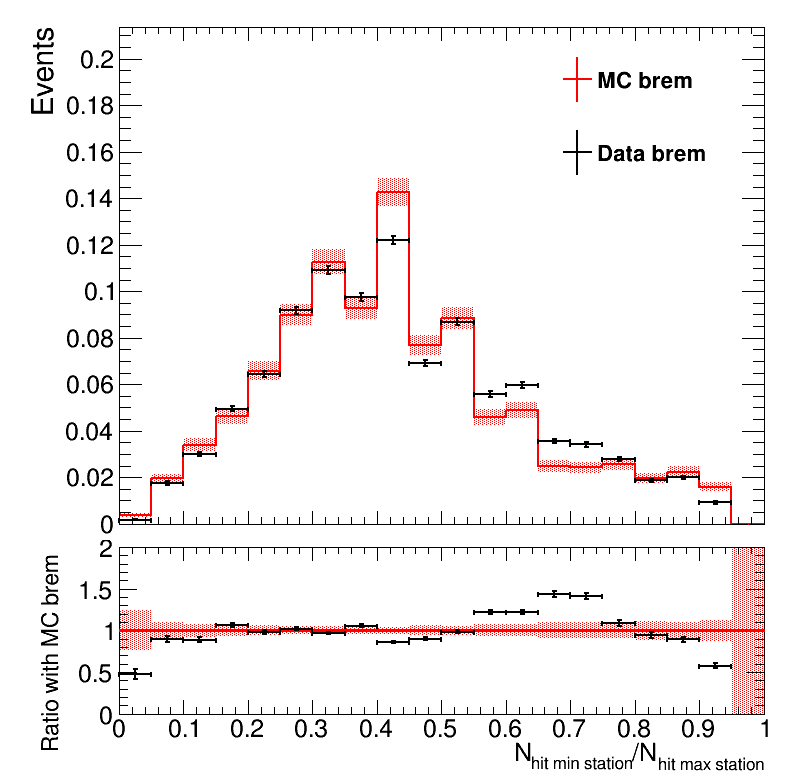

In [99]:
# DT plots
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff

rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year'+year+\
'_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 80
else: Nrechits_cut = 100

# var = [clusterSize, clusterSizeNoise, clusterMB1Ratio, clusterNStation, clusterStationRatio, clusterNStationNoise, clusterStationRatioNoise]
# names = ['clusterSize',  'clusterSizeNoise', 'clusterMB1Ratio', 'clusterNStation', 'clusterStationRatio','clusterNStationNoise','clusterStationRatioNoise']
# title = ['N_{rechits}','N_{rechits}', 'MB1 ratio', 'N_{station}', 'N_{hit min station}/N_{hit max station}', 'N_{station}', 'N_{hit min station}/N_{hit max station}']


var = [clusterSizeNoise, clusterMB1Ratio, clusterNStationNoise, clusterStationRatioNoise]
names = ['clusterSizeNoise', 'clusterMB1Ratio', 'clusterNStationNoise', 'clusterStationRatioNoise']
title = ['N_{rechits}', 'MB1 ratio', 'N_{station}', 'N_{hit min station}/N_{hit max station}']


bins = [ [0, 30, 50, 60,80, 100, 150, 250, 500], [21,0,1.05],  [5,0,5], [20,0,1]]

ratio = [[0.5,1.5], [0.0,2.0], [0,3], [0,2]]

print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins)==len(ratio))
norm = 1
fit = 0
key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]
key_plot = ['data', 'data_152']
# key_plot = ['data_152',  'dy_'+m1+'_'+m2]
key_plot = ['data',  'dy_'+m1+'_'+m2]

for j,v in enumerate(var):
        
#     if not j == 2:continue

    h = {}
    h_ks = {}
    maximum = 0
    for i,k in enumerate(key_plot):
        
        selections = [
            clusterSizeNoise[k]>=80,
            clusterMB1Ratio[k]<0.9,
            clusterNStationNoise[k] < 4,
            clusterStationRatioNoise[k]<=0.4,
        ]
        sel = clusterSizeNoise[k]>=50
        if not j == 0 and not j == 3:sel = np.logical_and(sel, clusterSizeNoise[k]>=80)
        if not j == 1:sel = np.logical_and(sel, clusterMB1Ratio[k]<0.9)
        if j == 3: sel = np.logical_and(sel, clusterNStationNoise[k]==4)

        total_weight = pileupWeight[k]* weight[k]*mc_corr_weight[k]
        total_weight = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[cond[k]]
        if 'data' in k:print(len(total_weight))
        h[k] = create_TH1D( v[k][sel], axis_title=[title[j], 'Events'], name=k, binning=bins[j], weights = total_weight[sel])
        if 'data' in k:h[k] = create_TH1D( v[k][sel], axis_title=[title[j], 'Events'], name=k, binning=bins[j])
        if norm: h[k].Scale(1./h[k].Integral())
        h[k].SetLineColor(std_color_list[i])

        new_cond = selections[j][sel]
        
        if j == 0:
            
            if 'dy' in k:
                for cut in Nrechits_cut+np.arange(10):
                    temp = np.logical_and(new_cond, clusterSize[k][sel]>=cut)
                    hm = create_TH1D( np.ones((np.count_nonzero(temp),)), name=k, binning=[1,0,2], weights = total_weight[sel][temp])
#                     hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
                    temp =  clusterSize[k][sel]>=50
                    hb = create_TH1D( np.ones((np.count_nonzero(temp))), name=k, binning=[1,0,2],weights = total_weight[sel][temp])
                    eff = rt.TEfficiency(hm,hb)
                    print(k, cut, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond = 
            else:
                temp = np.logical_and(sel, clusterSize[k]>=50)
#                 hm = create_TH1D( np.ones((np.count_nonzero(clusterSize[k]>=Nrechits_cut),)), name=k, binning=[1,0,2], weights = total_weight[clusterSize[k]>=Nrechits_cut])
                hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2])
                hb = create_TH1D( np.ones((len(weight[k][cond[k]][temp]),)), name=k, binning=[1,0,2])
                eff = rt.TEfficiency(hm,hb)
                print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))#             new_cond =     
        else:
            hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
            hb = create_TH1D( np.ones((len(v[k][sel]),)), name=k, binning=[1,0,2],weights = total_weight[sel])
            eff = rt.TEfficiency(hm,hb)
            print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
            
            if j == 1 and fit:
                r = h[k].Fit('gaus')
                print(r)
    print(h[key_plot[1]].Integral(), h[key_plot[0]].Integral())
    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], \
                draw_opt = ['E2','E1']) 
        
    c.Draw()

    file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
    print(file_name)
    if norm: file_name += "_norm"
    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")



In [71]:
# DT plots
key_plot = ['data',  'dy_'+m1+'_'+m2]


for i,k in enumerate(key_plot):

    sel = clusterSizeNoise[k]>=50
    sel = np.logical_and(sel, clusterMB1Ratio[k]<0.9)

    new_cond = np.logical_or(clusterNStationNoise[k]<4, clusterStationRatioNoise[k]<0.4)[sel] #remove if both clusters are 4 stations
    total_weight = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[cond[k]]

    hm = create_TH1D( np.ones((np.count_nonzero(new_cond),)), name=k, binning=[1,0,2], weights = total_weight[sel][new_cond])
    hb = create_TH1D( np.ones((len(clusterSizeNoise[k][sel]),)), name=k, binning=[1,0,2],weights = total_weight[sel])
    eff = rt.TEfficiency(hm,hb)
    print(k, names[j]+' efficiency', eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))


/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year2017_muonShower_norm_V1p17v160_tag_probe/
4 4 4 4
data clusterStationRatioNoise efficiency 0.617381683612155 0.002130018819192725 0.0021345171403656105
dy_120_800 clusterStationRatioNoise efficiency 0.6213357717092975 0.0064543497726742205 0.0064543497726742205


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal


/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year2017__muonShower_norm_V1p17v160_tag_probe/
0.03
0.03 0 6.414195497079253e-07
Chi2 = 36.851556, Prob = 6.4142e-07, NDF = 5, igood = 0


Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: dy_120_800 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TH1D::Chi2TestX>: NORM option should be used together with UU option. It is ignored


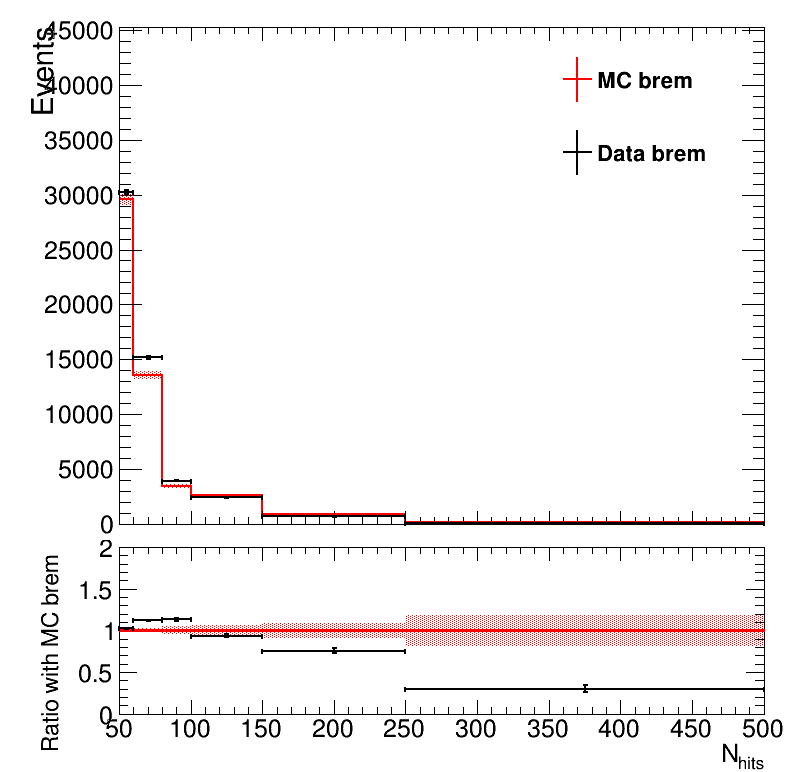

In [86]:
# simulate noise for Nhits and plot Nhits



#reweight nhits from each station

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year'+year+'_'+\
'_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 0
else: Nrechits_cut = 100

bins = [0, 30, 40,50, 60, 80, 100, 150, 250, 500]

bins = [50, 60, 80, 100, 150, 250, 500]

key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]
key_plot = ['data', 'dy_'+m1+'_'+m2]
# norm = 0
# reweight_flag = 1
# mb1_cut = 0 ### 0: no cut; 1: MB1 ratio < 0.9; 2: MB1 veto
    
for norm in [0,1]:
    for reweight_flag in [0,1]:
        for mb1_cut in [0,1,2]:
            if not (norm == 0  and reweight_flag == 1 and mb1_cut == 1):continue
            for prob in [0.01,0.02,0.03,0.04,0.05, 0.06, 0.07, 0.08]:
                if not prob == 0.03:continue
                print(prob)
                for i,k in enumerate(key_plot):
                    selections = [
                    clusterSize[k]>=Nrechits_cut,
                    ]
                    if mb1_cut == 1:selections.append(clusterMB1Ratio[k]<0.9)
                    elif mb1_cut == 2:selections.append(clusterMatchMB1[k]<=1)
                    sel = clusterSize[k]>=0
                    for l, s in enumerate(selections):
                        sel = np.logical_and(sel, s)
                    total_weight = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[cond[k]]
                    ##### reweighting #####
                    nNoiseHits = np.zeros((4,len(clusterNSegmentStation2[k])))
                    if 'dy' in k and reweight_flag:
                        reweight_product = np.ones(total_weight.shape)
                        for j in range(4):# loop over every station
                            nLayer = 12
                            if j == 3: nLayer = 8
                            
                            nNoiseHits[j] = np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(clusterNSegmentStation2[k]),nLayer))<prob,axis=1)
                    if 'data' in k:
                        h[k] = create_TH1D( clusterSize[k][sel], axis_title=['N_{hits}', 'Events'], name=k, binning=bins, weights = total_weight[sel])
                        hm = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel]>=80)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2], weights = total_weight[sel][clusterSize[k][sel]>=80])
                        hb = create_TH1D( np.ones(np.count_nonzero(clusterSize[k][sel]>=50)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2], weights = total_weight[sel][clusterSize[k][sel]>=50])
                        eff = rt.TEfficiency(hm,hb)
#                         print(k, np.sum(total_weight[sel][clusterSize[k][sel]>=80])/np.sum(total_weight[sel][clusterSize[k][sel]>=50]), eff.GetEfficiency(1), eff.GetEfficiencyErrorUp(1), eff.GetEfficiencyErrorLow(1))


                    else:
                        h[k] = create_TH1D( clusterSize[k][sel]+np.sum(nNoiseHits, axis = 0)[sel], axis_title=['N_{hits}', 'Events'], name=k, binning=bins, weights = total_weight[sel])
                        weighted_size = clusterSize[k][sel]+np.sum(nNoiseHits, axis = 0)[sel]
#                         for hit in [80,81,82,83,84,85]:
#                             hm = create_TH1D( np.ones(np.count_nonzero(weighted_size>=hit)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2], weights = total_weight[sel][weighted_size>=hit])
#                             hb = create_TH1D( np.ones(np.count_nonzero(weighted_size>=50)), axis_title=['N_{hits}', 'Events'], name=k, binning=[1,0,2], weights = total_weight[sel][weighted_size>=50])
#                             eff = rt.TEfficiency(hm,hb)
#                             print(k,  '\t',hit, '\t',np.sum(total_weight[sel][weighted_size>=hit])/np.sum(total_weight[sel][weighted_size>=50]),  '\t',eff.GetEfficiency(1),  '\t',eff.GetEfficiencyErrorUp(1),  '\t',eff.GetEfficiencyErrorLow(1))
                    if norm: h[k].Scale(1./h[k].Integral())
                    h[k].SetLineColor(std_color_list[i])

                c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.0,2], \
                            draw_opt = ['E2','E1']) 
                
                #print chi2 between data and MC
                print(prob, norm, h['data'].Chi2Test(h['dy_120_800'],'UW NORM P'))

                c.Draw()
                file_name = dir_name+region+'_clusterSize_withRatio_muonPt'+str(muonPt)+"_"+m1+'_'+m2
                file_name+='_mb1cut'+str(mb1_cut)
#                 print(file_name)
                if norm: file_name += "_norm"
                if reweight_flag:file_name+="_simulateNoiseProb"+str(prob).replace('.', 'p')

#                 c.SaveAs(file_name+".png")
#                 c.SaveAs(file_name+".C")



In [73]:
weighted_size = clusterSize[k][sel]+np.sum(nNoiseHits, axis = 0)[sel]
print(np.sum(total_weight[sel][weighted_size>80])/np.sum(total_weight[sel]))

0.034723546


In [ ]:
# simulate noise for Nhits and plot Nhits for each station separately




import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/MCData_shape_comparison_SingleMuon_year'+year+'_'+\
'_muonShower_'+scaling+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)
if region == 'dt': Nrechits_cut = 0
else: Nrechits_cut = 100

var = [clusterNSegmentStation1, clusterNSegmentStation2, clusterNSegmentStation3, clusterNSegmentStation4]
names = [ 'clusterNSegmentStation1', 'clusterNSegmentStation2', 'clusterNSegmentStation3', 'clusterNSegmentStation4']
title = [      'clusterNSegmentStation1', 'clusterNSegmentStation2', 'clusterNSegmentStation3', 'clusterNSegmentStation4']

bins = [ [50,0,50], [50,0,50], [50,0,50], [50,0,50]]

bins = [ list(np.arange(20))+[20,25,30,35,40,50]]*4

print(len(var) , len(title) , len(names) , len(bins))
assert(len(var) == len(title) == len(names) == len(bins))
key_plot = ['data_'+m1+'_'+m2, 'dy_'+m1+'_'+m2]
# norm = 0
# reweight_flag = 1
# mb1_cut = 0 ### 0: no cut; 1: MB1 ratio < 0.9; 2: MB1 veto
    
for norm in [0,1]:
    for reweight_flag in [0,1]:
        for mb1_cut in [0,1,2]:
#             if not (norm == 0 and reweight_flag and mb1_cut == 0):continue
            for prob in np.arange(0.01,0.15,0.01):
                for j, v in enumerate(var):# loop over every station
#                     if not (j == 0 and prob == 0.09):continue
                    for i,k in enumerate(key_plot):
                        selections = [
                        clusterSize[k]>=Nrechits_cut,
                        ]
                        if mb1_cut == 1:selections.append(clusterMB1Ratio[k]<0.9)
                        elif mb1_cut == 2:selections.append(clusterMatchMB1[k]<=1)
                        sel = clusterSize[k]>=0
                        for l, s in enumerate(selections):
                            sel = np.logical_and(sel, s)
                        total_weight = (pileupWeight[k]* weight[k]*mc_corr_weight[k])[cond[k]]
                        ##### reweighting #####
                        nNoiseHits = np.zeros((4,len(v[k])))
                        if 'dy' in k and reweight_flag:
                            reweight_product = np.ones(total_weight.shape)
                            nLayer = 12
                            if j == 3: nLayer = 8

                            nNoiseHits[j] = np.count_nonzero(np.random.uniform(low=0.0, high=1.0, size=(len(v[k]),nLayer))<prob,axis=1)
                        if 'data' in k:
                            h[k] = create_TH1D( var[j][k][sel], axis_title=['N_{hits}', 'Events'], name=k, binning=bins[j], weights = total_weight[sel])
                        else:
                            h[k] = create_TH1D( var[j][k][sel]+nNoiseHits[j][sel], axis_title=['N_{hits}', 'Events'], name=k, binning=bins[j], weights = total_weight[sel])
                        if norm: h[k].Scale(1./h[k].Integral())
                        h[k].SetLineColor(std_color_list[i])

                    c = make_ratio_plot([h[key_plot[1]],h[key_plot[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.0,2], \
                                draw_opt = ['E2','E1']) 

                    c.Draw()
                    file_name = dir_name+region+'_'+names[j]+'_withRatio_muonPt'+str(muonPt)+"_"+m1+'_'+m2
                    file_name+='_mb1cut'+str(mb1_cut)
                    print(file_name)
                    if norm: file_name += "_norm"
                    if reweight_flag:file_name+="_simulateNoiseProb"+str(round(prob,2)).replace('.', 'p')

                    c.SaveAs(file_name+".png")
                    c.SaveAs(file_name+".C")



In [91]:
np.arange(0.01,2,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

array([ 6,  9, 11,  9, 10])